# **COLLEGAMENTO AL DRIVE**

In [15]:
%reset -f
# Collegamento al drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)                               # Indirizzo base del drive 

Mounted at /content/drive


# **LIBRERIE**

In [16]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Garbage_Detection/GARBAGE_DETECTION')

import my_stretch as st                               # Importa la libreria proprietaria my_stretch

In [17]:
!reset -f
import numpy as np                                    # Importa Numpy
import matplotlib.pyplot as plt                       # Importa il modulo  pyplot di MatPlotLib
import skimage.io as io                               # Importa il modulo Input/ouput di SK-Image
from tensorflow import keras                          # Importa il modulo Keras di TensorFlow
import cv2                                            # Importa cv2
import os                                             # Importa os                             
import fnmatch                                        # Importa fnmatch
import skimage.io as io                               # Importa il modulo Input/ouput di SK-Image
from skimage.transform import resize                  # Importa il modulo resize da SK-Image
from os import listdir                                # Importa il modulo listdir da OS

from functools import lru_cache                       # Importa il modulo lru_cache da functools
from matplotlib.collections import PatchCollection    # Importa PatchCollection dal modulo collections di MatPlotLib

from PIL import Image                                 # Importa il modulo Image da PIL

!pip install git+https://github.com/qubvel/segmentation_models
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm                      # Importa Segmentation Models usando il framework Keras
from segmentation_models.metrics import iou_score     # Importa iou_score dal modulo Metrics di Segmentation Models

reset: invalid option -- 'f'
Usage: tset [options] [terminal]

Options:
  -c          set control characters
  -e ch       erase character
  -I          no initialization strings
  -i ch       interrupt character
  -k ch       kill character
  -m mapping  map identifier to type
  -Q          do not output control key settings
  -q          display term only, do no changes
  -r          display term on stderr
  -s          output TERM set command
  -V          print curses-version
  -w          set window-size

If neither -c/-w are given, both are assumed.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-np2g8ij_
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-np2g8ij_
  Running command git submodule update --init --recursive -q


# **PATH**

In [18]:
data_path = '/content/drive/MyDrive/Garbage_Detection'                    # Path del progetto
weight_path = '/content/drive/MyDrive/Garbage_Detection/pesi_ST/27.h5'    # Path dei pesi
phone_path = data_path + '/Phone_Data'                                                # Path delle immagini da cellulare

# **ISTANZIAMENTO RETE PER IL TRAINING E COMPILE E CARICAMENTO PESI**

In [19]:
# ISTANZIAMENTO RETE
BACKBONE = 'resnet34'                                     # Rete Neurale di Encoding per la rete Unet
model = sm.Unet(BACKBONE,                                 # Modello utilizzato come estrattore di feature di basso livello per costruire il modello di segmentazione
                input_shape=(None, None, 3),              # Modello in grado di lavorare su qualsiasi dimensione
                classes=1,                                 
                activation='sigmoid',                     # L’output è in [0, 1] il che assicura un training più stabile durante la segmentazione con maschere
                weights=None, 
                encoder_weights='imagenet',               # Pre-formazione su ImageNet
                encoder_freeze=True,                      # Tutti i livelli dell'encoder sono settati come non addestrabili
                encoder_features='default', 
                decoder_block_type='upsampling', 
                decoder_filters=(256, 128, 64, 32, 16), 
                decoder_use_batchnorm=True) 

In [20]:
# Definizione die parametri per il training
model.compile(loss = keras.losses.binary_crossentropy,                          # Loss-Function: Binary Cross-Entropy  dato che assume valori in [0;1]
              optimizer = keras.optimizers.SGD(learning_rate=0.06),             # Algoritmo di ottimizzazione: Stochastic Gradient Descent (SGD), lr: 0.06
              metrics = [iou_score, ])                                          # Misura di performance: Intersaction over Union, non influenzato dall'area da segmentare

In [21]:
model.load_weights(weight_path)                                                 # Caricamento pesi

# **DEFINIZIONE FUNZIONE DI STRETCH**

In [27]:
@lru_cache(maxsize=None)          # Dimensione della cache (default:128, con None non diamo un limite ma consumiamo molte risorse --> Colab)
def phone_stretch(batch_path, dimension):
  ''' 
    Prende un'immagine alla volta dal dataset di test per cellulari, la stretcha a dimensione quadrata e la carica in un ndarray e lo memorizza in un  .npy (utilizza lru_cache)
    ----------
    PARAMETRI:
      batch_path: indirizzo dei batch del dataset
          string
      dimension: dimensione dell'immagine quadrata in uscita
          int

    ----------
    RETURN:
      numpy.ndarray
          4D-array (number_img x dimension x dimension X channel)
  ''' 
  list_img_stretched = list()                                                   # Crea una lista vuota per le immagini stretchate

  #filtro per soli jpg
  print('Ci sono ' + str(len( fnmatch.filter(os.listdir(batch_path), '*.jpg' ) ))  + ' immagini da cellulare \n')

  # listdir: restituisce un elenco contenente i nomi delle voci nella directory data dal path
  for fname in sorted( fnmatch.filter(os.listdir(batch_path), '*.jpg' ) ):                               

    img = np.float32(io.imread(batch_path + '/' + fname))/255                   # Legge e normalizza le immagini 

    img_stretched = resize(img, (dimension, dimension), order=0)                # Stretcha le immagini in formato 512x512 con interpolazione Nearest-Neighbour
    img_stretchedbn = np.expand_dims(img_stretched, axis=-1)                    # Aggiunge la quarta dimensione
    
    list_img_stretched.append(img_stretchedbn)                                  # Aggiunge un elemento alla fine dell'elenco


  npa_stretched = np.array(list_img_stretched)                                  # Crea un array di tutte le immagini stretchate
  
  phone_img = np.resize( npa_stretched, (len(npa_stretched), 480, 480, 3)) 
  st.array_on_file(phone_path + '/phone.npy', phone_img)


  return phone_img

# **DEFINIZIONE DI FUNZIONE PER PREDIZIONE**

In [23]:
@lru_cache(maxsize=None)
def phone_predict(ID, phone_path):
    ''' 
      Stampa l'immagine predetta con accanto l'originale e la segmentata
      ----------
      PARAMETRI:
        ID: id dell'immagine scelta [1, len]
          int
        phone_path: stringa del path per le foto da cellulare
          string
      ----------
    ''' 

    phone_img = st.array_from_file(phone_path + '/phone.npy')

    # Prende singola immagine di TEST
    img = phone_img[ID, :] 


    # PREDIZIONE SU SINGOLA IMMAGINE DI TEST
    img_sing = np.expand_dims(img, axis=0)
    pred = model.predict(img_sing) 


    # Preparazione al plot della predetta:
    pred_img = pred[0,:] 
    pred_img = np.resize(pred, (480,480))

    # PLOT
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.title('ORIGINALE N°%d'%ID)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.title('PREDETTA N°%d'%ID)
    plt.imshow(pred_img, clim=[0,1])

In [24]:
@lru_cache(maxsize=None)
def predict_phone_batch(phone_path):
    ''' 
      Stampa tutte le immagini predette con accanto l'originale dalla cartella del cellulare
      ----------
      PARAMETRI:
        phone_path: stringa del path per le foto da cellulare
          string
      ----------
    ''' 

    phone_img = st.array_from_file(phone_path + '/phone.npy')

    for ID in range(1,len(phone_img)):

      # Prende singola immagine di TEST
      img = phone_img[ID, :] 


      # PREDIZIONE SU SINGOLA IMMAGINE DI TEST
      img_sing = np.expand_dims(img, axis=0)
      pred = model.predict(img_sing) 


      # Preparazione al plot della predetta:
      pred_img = pred[0,:] 
      pred_img = np.resize(pred, (480,480))

      # PLOT
      plt.figure(figsize=(18,6))
      plt.subplot(1,3,1)
      plt.title('ORIGINALE N°%d'%ID)
      plt.imshow(img)
      plt.subplot(1,3,2)
      plt.title('PREDETTA N°%d'%ID)
      plt.imshow(pred_img, clim=[0,1])

# **PHONE INPUT TEST**

In [28]:
# CARICA LE IMG DEL CELLULARE STRETCHATE SU UN VETTORE NPY

dimension= 480        # Dimensioni immagini quadrate stretchate

phone_img = phone_stretch(phone_path, dimension)
print(phone_img.shape)

Ci sono 40 immagini da cellulare 

(40, 480, 480, 3)


In [29]:
# PREDIZIONE IMMAGINI DA CELLULARE
predict_phone_batch(phone_path)

Output hidden; open in https://colab.research.google.com to view.

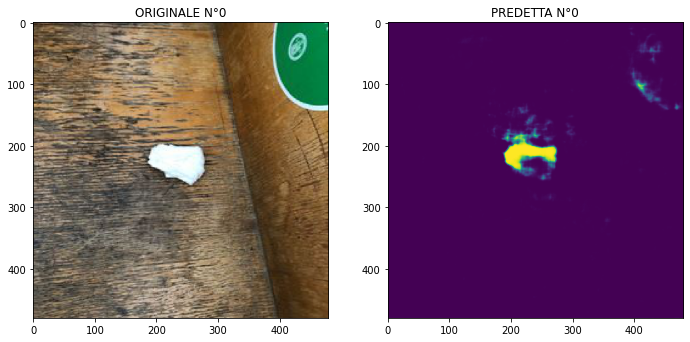

In [30]:
# PREDIZIONE SINGOLA IMMAGINE DA CELLULARE
phone_predict(0, phone_path)